# KNN method to classify speaker

<h3> Preprocess data

Import packages:  
pyAudioAnalysis can provide feature extraction functions to extract MFCCs

In [1]:
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

We use short-term feature extraction.  
It splits the input signal into short-term widnows (frames) and computes a number of features for each frame.  
This process leads to a sequence of short-term feature vectors for the whole signal.

For speakers from 3 different region (Mandarin, Spanish, English), we combine all the features extracted from the sound file and label them into one csv file (dataset.csv)  
Label are as follows:  
Mandarin - 0
English  - 1
Spanish  - 2

In [3]:
# preprocessing the sound file and label it (English)
path = "unified/eng/"
directory = os.fsencode(path)

for file in os.listdir(directory):
     filename = os.fsdecode(file)
     if filename.endswith(".mp3.wav"):
        # process each sound file individually, read audio file
        [Fs, x] = audioBasicIO.readAudioFile("unified/eng/"+filename);
        # extract the short term feature sequences for an audio signal, 
        # using a frame size of 50 msecs and a frame step of 25 msecs (50% overlap)
        F, f_names = audioFeatureExtraction.stFeatureExtraction(x, Fs, 0.050*Fs, 0.025*Fs);
        df = pd.DataFrame()
        df['label'] = []
        for i in range(0,22):
            df[f_names[i]] = F[i,:]
            df['label'] = '1'
        with open('dataset.csv', 'a') as f:
            df.to_csv(f, header=False)

     else:
         continue

In [4]:
# preprocessing the sound file and label it (Mandarin)
path = "unified/man/"
directory = os.fsencode(path)

for file in os.listdir(directory):
     filename = os.fsdecode(file)
     if filename.endswith(".mp3.wav"):
        [Fs, x] = audioBasicIO.readAudioFile("unified/man/"+filename);
        F, f_names = audioFeatureExtraction.stFeatureExtraction(x, Fs, 0.050*Fs, 0.025*Fs);
        df = pd.DataFrame()
        df['label'] = []
        for i in range(0,22):
            df[f_names[i]] = F[i,:]
            df['label'] = '0'
        with open('dataset.csv', 'a') as f:
            df.to_csv(f, header=False)

     else:
         continue

In [5]:
# preprocessing the sound file and label it (Spanish)
path = "unified/span/"
directory = os.fsencode(path)

for file in os.listdir(directory):
     filename = os.fsdecode(file)
     if filename.endswith(".mp3.wav"):
        [Fs, x] = audioBasicIO.readAudioFile("unified/span/"+filename);
        F, f_names = audioFeatureExtraction.stFeatureExtraction(x, Fs, 0.050*Fs, 0.025*Fs);
        df = pd.DataFrame()
        df['label'] = []
        for i in range(0,22):
            df[f_names[i]] = F[i,:]
            df['label'] = '2'
        with open('dataset.csv', 'a') as f:
            df.to_csv(f, header=False)

     else:
         continue

<h3> This is a sample table for the features extracted:

 We have chose 23 features in total:  
 1 - Zero Crossing Rate  
 2 - Energy  
 3 - Entropy of Energy  
 4 - Spectral Centroid  
 5 - Spectral Spread  
 6 - Spectral Entropy  
 7 - Spectral Flux  
 8 - Spectral Rolloff  
 9-21 - MFCCs
 
 
 

In [6]:
df = pd.DataFrame()
df['label'] = []
for i in range(0,21):
    df[f_names[i]] = F[i,:]
    df['label'] = '1'
#     print(df[f_names[i]])
 
df.head(5)

,label,zcr,energy,energy_entropy,spectral_centroid,spectral_spread,spectral_entropy,spectral_flux,spectral_rolloff,mfcc_1,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,1,0.057221,0.000237,2.755399,0.090283,0.104340,0.285444,0.000000,0.081670,-29.993441,...,-0.251487,-0.458450,-0.304126,0.699856,0.262700,-0.192292,-0.078255,-0.228530,-0.179618,-0.392052
1,1,0.049046,0.000524,3.061092,0.114757,0.158950,0.343493,0.008553,0.081670,-28.950253,...,-0.173034,-0.540374,-0.320536,0.490255,-0.069050,-0.517013,-0.603809,-0.482337,-0.530005,-0.113918
2,1,0.049955,0.001018,3.152675,0.104720,0.134262,0.363983,0.007162,0.081670,-27.693468,...,-0.420531,-0.628709,-0.178907,0.455753,-0.112649,-0.344607,-0.482470,-0.289777,-0.526684,-0.043278
3,1,0.052679,0.005360,2.711283,0.085584,0.104967,0.127749,0.025232,0.059891,-26.858023,...,-1.014324,-0.964195,0.005080,0.590279,-0.030126,0.008122,-0.238700,-0.618518,-0.397906,-0.237425
4,1,0.045413,0.012678,2.865745,0.073921,0.089234,0.055784,0.020797,0.047187,-26.121482,...,-1.402858,-0.732671,0.099542,0.801399,0.118026,0.096287,0.049511,-0.380714,-0.276723,-0.264528


<h3> Classification part using KNN and XGBoost

Import packages:

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

Read file and create dataframe, create training and testing data

Firstly, we used all 22 features extracted from the audio

In [4]:
df = pd.read_csv('dataset.csv',index_col = 0)
x = df[['zcr','energy','energy_entropy','spectral_centroid','spectral_spread','spectral_entropy','spectral_flux','spectral_rolloff','mfcc_1','mfcc_2','mfcc_3','mfcc_4','mfcc_5','mfcc_6','mfcc_7','mfcc_8','mfcc_9','mfcc_10','mfcc_11','mfcc_12','mfcc_13','chroma_1']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y,test_size=0.33)

Build KNN Classifier and fit in the model, print the prediction accuracy, f1 score and confusion matrix

We compared different prediction accuracy with different numbers of neighbours (3, 5, 7, 10)

Accuracy: 0.5899787347155768
              precision    recall  f1-score   support

    Mandarin       0.25      0.31      0.28     17117
     English       0.70      0.75      0.72     98226
     Spanish       0.45      0.34      0.39     42661

    accuracy                           0.59    158004
   macro avg       0.47      0.47      0.46    158004
weighted avg       0.58      0.59      0.58    158004



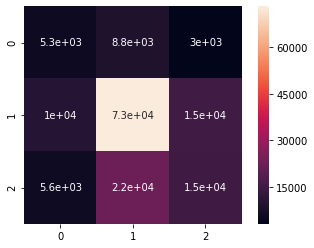

In [5]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

target_names = ['Mandarin', 'English', 'Spanish']
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
cm_plot = sns.heatmap(cm, annot=True, square=True)

Accuracy: 0.6186805397331713
              precision    recall  f1-score   support

    Mandarin       0.32      0.23      0.26     17117
     English       0.68      0.83      0.75     98226
     Spanish       0.47      0.29      0.36     42661

    accuracy                           0.62    158004
   macro avg       0.49      0.45      0.46    158004
weighted avg       0.59      0.62      0.59    158004



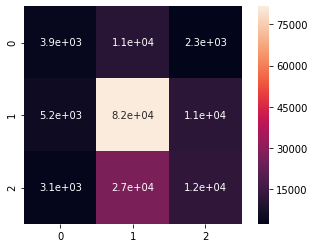

In [6]:
from sklearn import metrics
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

target_names = ['Mandarin', 'English', 'Spanish']
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
cm_plot = sns.heatmap(cm, annot=True, square=True)

Accuracy: 0.627287916761601
              precision    recall  f1-score   support

    Mandarin       0.38      0.16      0.23     17117
     English       0.67      0.86      0.76     98226
     Spanish       0.47      0.27      0.34     42661

    accuracy                           0.63    158004
   macro avg       0.51      0.43      0.44    158004
weighted avg       0.59      0.63      0.59    158004



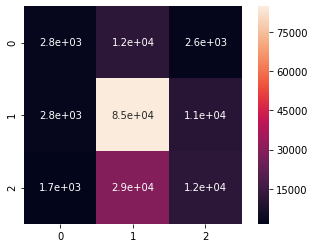

In [7]:
from sklearn import metrics
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

target_names = ['Mandarin', 'English', 'Spanish']
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
cm_plot = sns.heatmap(cm, annot=True, square=True)

Accuracy: 0.6331358699779752
              precision    recall  f1-score   support

    Mandarin       0.42      0.12      0.19     17117
     English       0.66      0.90      0.76     98226
     Spanish       0.48      0.23      0.31     42661

    accuracy                           0.63    158004
   macro avg       0.52      0.42      0.42    158004
weighted avg       0.59      0.63      0.58    158004



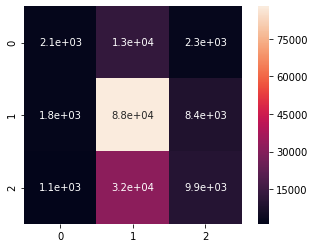

In [8]:
from sklearn import metrics
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

target_names = ['Mandarin', 'English', 'Spanish']
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
cm_plot = sns.heatmap(cm, annot=True, square=True)

It seems that the prediction accuracy are pretty much the same and around 0.63. Hower, with number of neighbors increase, the prediction accuracy slightly increases too.

Build XGBoost Classifier and fit in the model, print the prediction accuracy, f1 score and confusion matrix.

Accuracy: 0.6342497658287132
              precision    recall  f1-score   support

    Mandarin       0.54      0.03      0.06     17117
     English       0.64      0.97      0.77     98226
     Spanish       0.54      0.09      0.16     42661

    accuracy                           0.63    158004
   macro avg       0.57      0.37      0.33    158004
weighted avg       0.60      0.63      0.53    158004



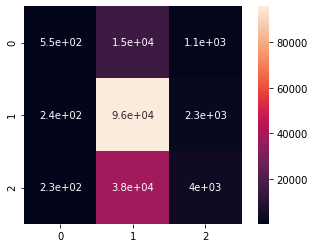

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

xgb_c = XGBClassifier(max_depth=10, n_estimators=100, n_jobs=-1, num_class=3) 
xgb_c.fit(X_train, y_train.ravel())
y_pred = xgb_c.predict(X_test) ##predict
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

target_names = ['Mandarin', 'English', 'Spanish']
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
cm_plot = sns.heatmap(cm, annot=True, square=True)

Then we only use mfcc features to train the data to see if there is any difference

KNN

Accuracy: 0.621275410749095
              precision    recall  f1-score   support

    Mandarin       0.37      0.15      0.21     15561
     English       0.67      0.86      0.75     89296
     Spanish       0.45      0.26      0.33     38783

    accuracy                           0.62    143640
   macro avg       0.50      0.42      0.43    143640
weighted avg       0.58      0.62      0.58    143640



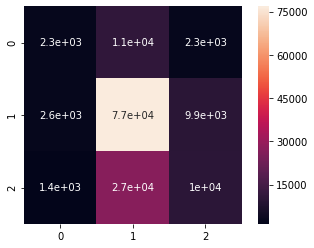

In [11]:
x = df[['mfcc_1','mfcc_2','mfcc_3','mfcc_4','mfcc_5','mfcc_6','mfcc_7','mfcc_8','mfcc_9','mfcc_10','mfcc_11','mfcc_12','mfcc_13']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3)
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

target_names = ['Mandarin', 'English', 'Spanish']
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
cm_plot = sns.heatmap(cm, annot=True, square=True)

XGBoost

Accuracy: 0.6282790309106099
              precision    recall  f1-score   support

    Mandarin       0.54      0.02      0.04     15561
     English       0.63      0.98      0.77     89296
     Spanish       0.51      0.05      0.10     38783

    accuracy                           0.63    143640
   macro avg       0.56      0.35      0.30    143640
weighted avg       0.59      0.63      0.51    143640



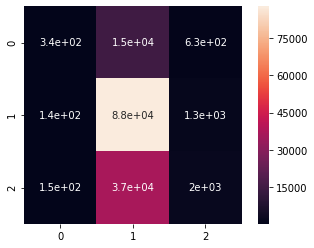

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

x = df[['mfcc_1','mfcc_2','mfcc_3','mfcc_4','mfcc_5','mfcc_6','mfcc_7','mfcc_8','mfcc_9','mfcc_10','mfcc_11','mfcc_12','mfcc_13']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3)
xgb_c = XGBClassifier(max_depth=10, n_estimators=100, n_jobs=-1, num_class=3) 
xgb_c.fit(X_train, y_train.ravel())
y_pred = xgb_c.predict(X_test) ##predict
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

target_names = ['Mandarin', 'English', 'Spanish']
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
cm_plot = sns.heatmap(cm, annot=True, square=True)

It seems there is no such a big difference between using 22 features and 13 mfcc features

To optimize our model we try to normalize the input data:

In [14]:
def normalize(x):
    return (x-x.mean())/x.std()

In [16]:
# normalize mfcc features
dataframe = pd.read_csv('dataset.csv',index_col = 0)
x = dataframe[['mfcc_1','mfcc_2','mfcc_3','mfcc_4','mfcc_5','mfcc_6','mfcc_7','mfcc_8','mfcc_9','mfcc_10','mfcc_11','mfcc_12','mfcc_13']]
normalized_x = pd.DataFrame()
count = 1
for i in x:
    i = normalize(dataframe[i])
    normalized_x["mfcc"+ str(count)] = i
    count = count + 1

normalized_x.head(10)

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13
0,-1.366721,-1.092069,-0.014589,1.673276,1.689741,0.498789,0.098053,0.711796,0.709506,0.203857,0.143414,0.937126,0.976330
1,-1.270844,-0.978530,0.132655,1.527600,1.234789,0.603791,0.326731,1.600346,0.331231,-0.190566,-0.257535,0.723589,0.667438
2,-1.279251,-1.086657,-0.022859,1.074859,0.817529,0.501960,0.511110,0.948588,0.028872,-0.248314,-0.264864,0.844052,-0.036431
3,-1.377505,-1.026755,-0.088889,1.001777,1.066652,0.437346,0.444312,0.748578,0.550123,0.445194,0.542568,1.509753,0.688372
4,-1.436626,-0.865647,0.091126,1.135194,0.953060,0.470755,0.117077,0.961370,0.902763,0.153268,0.745510,1.139576,1.218763
5,-1.471196,-0.974707,0.252347,1.405756,0.824157,0.042115,-0.331951,0.352664,0.612725,0.463939,0.391719,0.991807,0.845736
6,-1.449797,-0.722354,0.024903,1.514353,1.350594,0.679278,0.662948,0.608575,0.414390,0.436025,0.692049,1.277221,0.787689
7,-1.639612,-0.761026,0.160842,1.606279,1.459162,0.600331,0.600508,0.763964,-0.224947,-0.072366,0.984137,1.199470,0.832116
8,-1.714263,-0.951005,0.052317,1.361294,1.262125,0.843315,-0.014770,0.674308,-0.340387,-0.213699,0.702508,1.160154,0.911240
9,-1.552914,-0.987817,0.078971,1.108526,0.782073,0.700300,1.082980,1.497345,0.573797,0.119164,0.578165,1.367355,1.217061


Show the table that contains 478800 entries of data

In [17]:
dataframe.describe()

,label,zcr,energy,energy_entropy,spectral_centroid,spectral_spread,spectral_entropy,spectral_flux,spectral_rolloff,mfcc_1,...,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,chroma_1
count,478800.000000,478800.000000,478800.000000,478800.000000,478800.000000,478800.000000,4.788000e+05,478800.000000,478800.000000,478800.000000,...,478800.000000,478800.000000,478800.000000,478800.000000,478800.000000,478800.000000,478800.000000,478800.000000,478800.000000,4.788000e+05
mean,1.161667,0.138316,0.012083,3.072952,0.214487,0.200836,8.287646e-01,0.006608,0.206260,-26.793379,...,-0.323530,0.053969,-0.073894,-0.008552,-0.095378,-0.071741,-0.113041,-0.057503,-0.105271,2.034716e-02
std,0.593463,0.147643,0.018931,0.228431,0.131248,0.049075,7.668584e-01,0.007056,0.238092,2.420032,...,0.554736,0.465873,0.415311,0.362158,0.343331,0.327139,0.316236,0.319651,0.314870,3.515638e-02
min,0.000000,0.000000,0.000004,0.333757,0.003172,0.030122,7.503214e-07,0.000000,0.000000,-47.762011,...,-3.267421,-2.172960,-2.060405,-1.943886,-1.837495,-1.782610,-1.714220,-1.662052,-1.764887,2.274218e-11
25%,1.000000,0.047230,0.001421,2.986923,0.127713,0.166846,2.111611e-01,0.003090,0.045372,-28.399418,...,-0.690973,-0.255144,-0.350322,-0.241125,-0.318435,-0.277326,-0.306589,-0.250215,-0.294183,2.434024e-03
50%,1.000000,0.076294,0.005154,3.145891,0.164899,0.196857,5.521587e-01,0.005025,0.090744,-26.552168,...,-0.311706,0.049421,-0.067579,0.001638,-0.082891,-0.059318,-0.093479,-0.037107,-0.084058,6.756622e-03
75%,2.000000,0.158038,0.014707,3.233517,0.254569,0.230491,1.247080e+00,0.008010,0.261343,-25.010996,...,0.053639,0.353329,0.204030,0.233180,0.137778,0.145825,0.099508,0.153462,0.101314,2.042029e-02
max,2.000000,0.897366,0.619221,3.321075,0.833006,0.400802,3.271169e+00,0.445985,0.965517,-20.293946,...,2.297223,2.377265,2.052533,2.107679,1.532954,1.954015,1.710319,1.778261,1.557266,3.261622e-01


In [18]:
y = dataframe['label']

KNN

Accuracy: 0.6200640490114174
              precision    recall  f1-score   support

    Mandarin       0.33      0.24      0.28     15561
     English       0.68      0.83      0.75     89296
     Spanish       0.47      0.29      0.36     38783

    accuracy                           0.62    143640
   macro avg       0.50      0.45      0.46    143640
weighted avg       0.59      0.62      0.59    143640



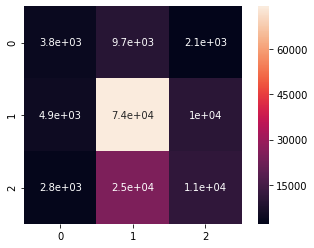

In [19]:
X_train, X_test, y_train, y_test = train_test_split(normalized_x, y, stratify=y, test_size=0.3)
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

target_names = ['Mandarin', 'English', 'Spanish']
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
cm_plot = sns.heatmap(cm, annot=True, square=True)

XGBoost

Accuracy: 0.6286131996658313
              precision    recall  f1-score   support

    Mandarin       0.54      0.02      0.04     15561
     English       0.63      0.98      0.77     89296
     Spanish       0.52      0.05      0.10     38783

    accuracy                           0.63    143640
   macro avg       0.56      0.35      0.30    143640
weighted avg       0.59      0.63      0.51    143640



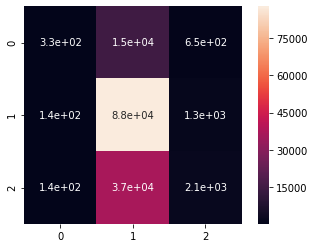

In [20]:
X_train, X_test, y_train, y_test = train_test_split(normalized_x, y, stratify=y, test_size=0.3)
xgb_c = XGBClassifier(max_depth=10, n_estimators=100, n_jobs=-1, num_class=3) 
xgb_c.fit(X_train, y_train.ravel())
y_pred = xgb_c.predict(X_test) ##predict
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

target_names = ['Mandarin', 'English', 'Spanish']
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
cm_plot = sns.heatmap(cm, annot=True, square=True)

Now we compare the model with normalized input with the unnormalized input, prediction accuracy is still very similar

We also tried to split the test data by audio file, for example, we find each audio file extracts 798 data records, we split the test data by 30% of English,Mandarin,Spanish audio files, so 112,19,49 files will be taken as test audio files, that's 180 in total. 

In [21]:
eng_x_test = normalized_x.iloc[0:89376]
eng_x_train = normalized_x.iloc[89376:297654]
man_x_test = normalized_x.iloc[297654:312816]
man_x_train = normalized_x.iloc[312816:349524]
span_x_test = normalized_x.iloc[349524:388626]
span_x_train = normalized_x.iloc[388626:478800]
print(span_x_train) 

        mfcc1     mfcc2     mfcc3     mfcc4     mfcc5     mfcc6     mfcc7  \
0   -0.172904  0.984969  0.910135  0.956940 -1.463915 -0.856273  0.767871   
1    0.564196  0.447614  0.377670  0.307957 -1.485418 -0.776060  0.296891   
2    0.543723  0.545370  0.898581  0.794602 -1.879760 -0.382586 -0.119853   
3    0.633786  0.334014  1.081994  0.238636 -1.226101  0.180228 -0.615795   
4    0.444130  0.245998  1.433295  0.073945 -0.758072  0.605848  0.058155   
5    0.252314  0.508330  1.785225 -0.698013 -1.205473 -0.480411 -0.878064   
6    0.136066  0.107140  0.926715 -0.171600  0.178284  0.040163 -0.612684   
7   -0.727852 -0.060058  1.411944  0.412422 -0.971629  0.348483 -0.255636   
8   -0.648311 -0.692491  0.031363  0.185709 -0.824808 -0.208398 -0.029135   
9   -0.760560 -0.659546  0.029595  1.554505 -0.309935  0.295719  0.796292   
10  -0.585475 -0.374795 -1.092678  0.856990 -0.920616  0.079916  1.866051   
11   0.205345  0.738155 -1.646673 -0.142941 -0.194923 -0.808480  2.858714   

In [22]:
X_train = normalized_x.iloc[np.r_[89376:297654, 312816:349524, 388626:478800 ]]
y_train = y.iloc[np.r_[89376:297654, 312816:349524, 388626:478800 ]]
X_test = normalized_x.iloc[np.r_[0:89376, 297654:312816, 349524:388626 ]]
y_test = y.iloc[np.r_[0:89376, 297654:312816, 349524:388626 ]]

We will find the prediciton of each time segment, then take the mode of the entire time frame of the audio file to determine the label.

KNN

In [31]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_realtest = []
y_pred = []
for i in range(0,180):
    y_predpiece = knn.predict(X_test.iloc[(i*797):(i*797+797)])
    counts = np.bincount(y_predpiece)
    # get mode
    y_predmode = np.argmax(counts)
#     print(y_predmode)
    y_pred.append(y_predmode)
    y_realtest.append(y_test.iloc[i*797])
print("Accuracy:",metrics.accuracy_score(y_realtest, y_pred))


Accuracy: 0.6277777777777778


              precision    recall  f1-score   support

    Mandarin       0.00      0.00      0.00        19
     English       0.63      1.00      0.77       113
     Spanish       0.00      0.00      0.00        48

    accuracy                           0.63       180
   macro avg       0.21      0.33      0.26       180
weighted avg       0.39      0.63      0.48       180



/home/tang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


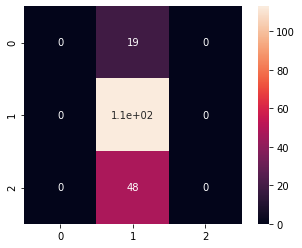

In [32]:
target_names = ['Mandarin', 'English', 'Spanish']
print(classification_report(y_realtest, y_pred, target_names=target_names))

cm = confusion_matrix(y_realtest, y_pred)
cm_plot = sns.heatmap(cm, annot=True, square=True)

In [33]:
print(y_realtest)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [34]:
print(y_pred)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


XGBoost

In [36]:
xgb_c = XGBClassifier(max_depth=10, n_estimators=100, n_jobs=-1, num_class=3) 
xgb_c.fit(X_train, y_train.ravel())
y_realtest = []
y_pred = []
for i in range(0,180):
    y_predpiece = knn.predict(X_test.iloc[(i*797):(i*797+797)])
    counts = np.bincount(y_predpiece)
    # get mode
    y_predmode = np.argmax(counts)
#     print(y_predmode)
    y_pred.append(y_predmode)
    y_realtest.append(y_test.iloc[i*797])
print("Accuracy:",metrics.accuracy_score(y_realtest, y_pred))


Accuracy: 0.6277777777777778


              precision    recall  f1-score   support

    Mandarin       0.00      0.00      0.00        19
     English       0.63      1.00      0.77       113
     Spanish       0.00      0.00      0.00        48

    accuracy                           0.63       180
   macro avg       0.21      0.33      0.26       180
weighted avg       0.39      0.63      0.48       180



/home/tang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


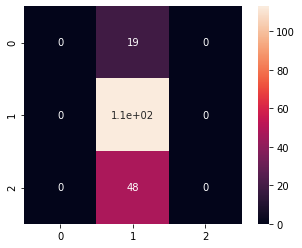

In [37]:
target_names = ['Mandarin', 'English', 'Spanish']
print(classification_report(y_realtest, y_pred, target_names=target_names))

cm = confusion_matrix(y_realtest, y_pred)
cm_plot = sns.heatmap(cm, annot=True, square=True)

However, we still find the accuracy remains the same

Use 60(10% of all data) of all test datas

KNN

In [38]:
import numpy as np
test_eng=np.arange(0,37)
test_man=np.arange(112,119)
test_span=np.arange(131,147)
test_vec=np.r_[test_eng,test_man,test_span]

In [39]:
print(test_vec)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36 112 113 114 115 116 117 118 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146]


In [41]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_realtest = []
y_pred = []
for i in test_vec:
    y_predpiece = knn.predict(X_test.iloc[(i*797):(i*797+797)])
    counts = np.bincount(y_predpiece)
    # get mode
    y_predmode = np.argmax(counts)
#     print(y_predmode)
    y_pred.append(y_predmode)
    y_realtest.append(y_test.iloc[i*797])
print("Accuracy:",metrics.accuracy_score(y_realtest, y_pred))

Accuracy: 0.6333333333333333


              precision    recall  f1-score   support

    Mandarin       0.00      0.00      0.00         7
     English       0.63      1.00      0.78        38
     Spanish       0.00      0.00      0.00        15

    accuracy                           0.63        60
   macro avg       0.21      0.33      0.26        60
weighted avg       0.40      0.63      0.49        60



/home/tang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


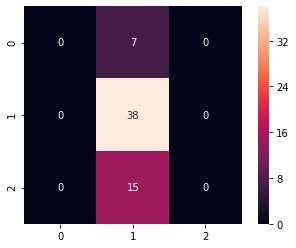

In [43]:
target_names = ['Mandarin', 'English', 'Spanish']
print(classification_report(y_realtest, y_pred, target_names=target_names))

cm = confusion_matrix(y_realtest, y_pred)
cm_plot = sns.heatmap(cm, annot=True, square=True)

XGBoost

In [45]:
xgb_c = XGBClassifier(max_depth=10, n_estimators=100, n_jobs=-1, num_class=3) 
xgb_c.fit(X_train, y_train.ravel())
y_realtest = []
y_pred = []
for i in test_vec:
    y_predpiece = knn.predict(X_test.iloc[(i*797):(i*797+797)])
    counts = np.bincount(y_predpiece)
    # get mode
    y_predmode = np.argmax(counts)
#     print(y_predmode)
    y_pred.append(y_predmode)
    y_realtest.append(y_test.iloc[i*797])
print("Accuracy:",metrics.accuracy_score(y_realtest, y_pred))


Accuracy: 0.6333333333333333


/home/tang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

    Mandarin       0.00      0.00      0.00         7
     English       0.63      1.00      0.78        38
     Spanish       0.00      0.00      0.00        15

    accuracy                           0.63        60
   macro avg       0.21      0.33      0.26        60
weighted avg       0.40      0.63      0.49        60



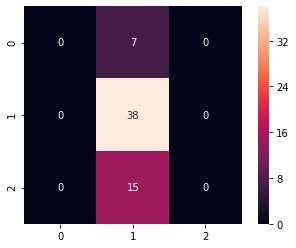

In [46]:
target_names = ['Mandarin', 'English', 'Spanish']
print(classification_report(y_realtest, y_pred, target_names=target_names))

cm = confusion_matrix(y_realtest, y_pred)
cm_plot = sns.heatmap(cm, annot=True, square=True)

As above, we find that all the test y are classified into english label so we wonder if the English audio file are too many. So we average the number of audio file to take 19 test audio files from each language region and 46 training audio files.

In [47]:
eng_x_test = normalized_x.iloc[0:15162]
eng_x_train = normalized_x.iloc[15162:51870]
man_x_test = normalized_x.iloc[297654:312816]
man_x_train = normalized_x.iloc[312816:349524]
span_x_test = normalized_x.iloc[349524:364686]
span_x_train = normalized_x.iloc[364686:401394]

In [48]:
X_train = normalized_x.iloc[np.r_[15162:51870, 312816:349524, 364686:401394 ]]
y_train = y.iloc[np.r_[15162:51870, 312816:349524, 364686:401394 ]]
X_test = normalized_x.iloc[np.r_[0:15162, 297654:312816, 349524:364686 ]]
y_test = y.iloc[np.r_[0:15162, 297654:312816, 349524:364686 ]]

KNN

In [49]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_realtest = []
y_pred = []
for i in range(0,57):
    y_predpiece = knn.predict(X_test.iloc[(i*797):(i*797+797)])
    counts = np.bincount(y_predpiece)
    # get mode
    y_predmode = np.argmax(counts)
#     print(y_predmode)
    y_pred.append(y_predmode)
    y_realtest.append(y_test.iloc[i*797])
print("Accuracy:",metrics.accuracy_score(y_realtest, y_pred))


Accuracy: 0.3333333333333333


              precision    recall  f1-score   support

    Mandarin       0.34      0.58      0.43        19
     English       0.27      0.20      0.23        20
     Spanish       0.40      0.22      0.29        18

    accuracy                           0.33        57
   macro avg       0.34      0.33      0.32        57
weighted avg       0.33      0.33      0.31        57



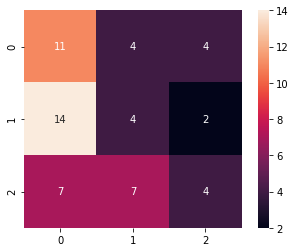

In [50]:
target_names = ['Mandarin', 'English', 'Spanish']
print(classification_report(y_realtest, y_pred, target_names=target_names))

cm = confusion_matrix(y_realtest, y_pred)
cm_plot = sns.heatmap(cm, annot=True, square=True)

In [51]:
print(y_realtest)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [52]:
print(y_pred)

[0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 2, 1, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 1, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0]


XGBoost

In [53]:
xgb_c = XGBClassifier(max_depth=10, n_estimators=100, n_jobs=-1, num_class=3) 
xgb_c.fit(X_train, y_train.ravel())
y_realtest = []
y_pred = []
for i in range(0,57):
    y_predpiece = knn.predict(X_test.iloc[(i*797):(i*797+797)])
    counts = np.bincount(y_predpiece)
    # get mode
    y_predmode = np.argmax(counts)
#     print(y_predmode)
    y_pred.append(y_predmode)
    y_realtest.append(y_test.iloc[i*797])
print("Accuracy:",metrics.accuracy_score(y_realtest, y_pred))


Accuracy: 0.3333333333333333


              precision    recall  f1-score   support

    Mandarin       0.34      0.58      0.43        19
     English       0.27      0.20      0.23        20
     Spanish       0.40      0.22      0.29        18

    accuracy                           0.33        57
   macro avg       0.34      0.33      0.32        57
weighted avg       0.33      0.33      0.31        57



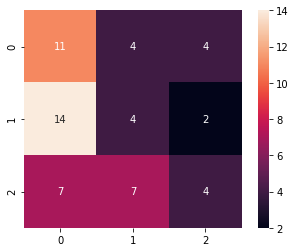

In [54]:
target_names = ['Mandarin', 'English', 'Spanish']
print(classification_report(y_realtest, y_pred, target_names=target_names))

cm = confusion_matrix(y_realtest, y_pred)
cm_plot = sns.heatmap(cm, annot=True, square=True)

We found the accuracy are even lower than before